In [1]:
!pip install mwparserfromhell
!pip install fa2
!pip install networkx

     |████████████████████████████████| 135 kB 7.7 MB/s eta 0:00:01
  Created wheel for mwparserfromhell: filename=mwparserfromhell-0.5.4-cp37-cp37m-macosx_10_7_x86_64.whl size=95233 sha256=b626a333355a3d9ffef8cb0ad44d37955aef8bdae12e68242e82ec8033145c82
  Stored in directory: /Users/teddi/Library/Caches/pip/wheels/fb/5e/32/21387964c6802f6f5686369fa9abd9eda040d5ef762fe9ca8c
Successfully built mwparserfromhell


In [210]:
import urllib.request as urllib2
import urllib
import re
import json
import pandas as pd
import numpy as np
import os
import networkx as nx
from collections import Counter
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
%matplotlib inline
import mwparserfromhell
from operator import itemgetter

In [211]:
# Example of a working query
query = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&titles=Harry%20Potter&rvprop=content&format=json&utf8=1'

We create the character lists by going through the character index of each book

In [212]:
# Create a list of all the wikilinks of characters and another list of in which book each character appeared first
wikilinks = []
book_nrs = []

books = ['Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)', 
'Harry_Potter_and_the_Chamber_of_Secrets_(character_index)', 
'Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)',
'Harry_Potter_and_the_Goblet_of_Fire_(character_index)',
'Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)',
'Harry_Potter_and_the_Half-Blood_Prince_(character_index)',
'Harry_Potter_and_the_Deathly_Hallows_(character_index)']

for book in books:

    # Get characters from each book book
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    title = book
    wikiresponse_list = urllib2.urlopen(baseurl+title) # generate the complete query url
    wikihtml_list = wikiresponse_list.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml_list) # Load the json 

    text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']

    links = re.findall(r"\[\[(.*?)\]\]", text)
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    book_nr = [books.index(book)+1 for i in range(len(set(links_clean)))]
    # Add indication which book the character first appeared in
    wikilinks.extend(set(links_clean))
    book_nrs.extend(book_nr)


In [213]:
df_wiki = pd.DataFrame(list(zip(wikilinks,book_nrs)), columns=['wiki','book'])

In [214]:
len(df_wiki)

810

In [215]:
df_wiki.head(5)

,wiki,book
0,Mandy Brocklehurst,1
1,Draco Malfoy's eagle owl,1
2,Quirinus Quirrell's first mountain troll,1
3,Lily J. Potter,1
4,Doris Crockford,1


In [216]:
# We have a few duplicates that we need to drop. We like to keep the first instance where the characters appeared
df_wiki = df_wiki.drop_duplicates(subset=['wiki'], keep='first')
len(df_wiki)

789

In [217]:
# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Now we must loop through all the character wikis and download all of their text into files
folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']
#for folder in folders:
#    os.mkdir(folder)

# Define the working directory
wd = os.getcwd()

### VILJUM GERA ÞETTA EFTIR Á - ANNARS KOMA REDIRECTED LINKAR EKKI INN RÉTT

# Add columns to the dataframe for the additional information
#df_wiki['text'] = None
#df_wiki['links'] = None

# Keep information about which links redirect -> That way we can make sure the information is displayed as correctly as possible
df_wiki['alternative_wiki'] = None

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd 
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Get info about the character
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    title = urllib.parse.quote(row.wiki)
    file_name = row.wiki

    print("Book: ", row.book, " Character: ", row.wiki)

    wikiresponse = urllib2.urlopen(baseurl+title) # generate the complete query url
    wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml) # Load the json 

    # Extract the page text from the json, these are located at different places 
    try:
        text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
    except:
        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
        except:
            if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                text = ''
   
    # Before we continue we must check if there is a redirect on the text - otherwise we will get no info on the character
    if text.startswith('#REDIRECT'):
        
        link = re.findall(r"\[\[(.*?)\]\]", text)
        new_title = urllib.parse.quote(link[0])
        print("WAS REDIRECTED TO: ", link[0])

        #Redo the steps above with the new_title
        wikiresponse = urllib2.urlopen(baseurl+new_title) # generate the complete query url
        wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
        wikijson = json.loads(wikihtml) # Load the json

        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
        except:
            try:
                text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
            except:
                if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                    text = ''

        # Update the wiki redirects to
        df_wiki.at[idx, 'alternative_wiki'] = link[0]
        file_name = link[0]



    # Create a txt file of the text contained on the wikipage
    file = open(file_name + '.txt', "w") 
    file.write(text) 
    file.close() 

    # Add information about links
    #links = re.findall(r"\[\[(.*?)\]\]", text)
    #links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    #links_clean = [l for l in links_clean if l in list(df_wiki.wiki)] #if l in df_wiki.wiki We don't want to add links to other things than the characters we already have
    
    # update the values in the dataframe
    #df_wiki.at[idx, "text"] = text
    #df_wiki.at[idx, "links"] = links_clean

# reset wd
os.chdir(wd)



Book:  1  Character:  Mandy Brocklehurst
Book:  1  Character:  Draco Malfoy's eagle owl
Book:  1  Character:  Quirinus Quirrell's first mountain troll
Book:  1  Character:  Lily J. Potter
Book:  1  Character:  Doris Crockford
Book:  1  Character:  Petunia Dursley
Book:  1  Character:  Blaise Zabini
Book:  1  Character:  Dennis
Book:  1  Character:  Susan Bones
Book:  1  Character:  Justin Finch-Fletchley
Book:  1  Character:  Prewett family
Book:  1  Character:  Rolanda Hooch
Book:  1  Character:  Marjorie Dursley
Book:  1  Character:  Keeper of Keys and Grounds
Book:  1  Character:  Gregory the Smarmy
Book:  1  Character:  Fang
Book:  1  Character:  Adalbert Waffling
Book:  1  Character:  Hengist of Woodcroft
Book:  1  Character:  Theodore Nott
Book:  1  Character:  Hogwarts Giant Squid
Book:  1  Character:  Lavender Brown
Book:  1  Character:  Norberta
Book:  1  Character:  King's Cross Station
Book:  1  Character:  Rowboat owner
Book:  1  Character:  Cornelius Agrippa
Book:  1  Char

Book:  2  Character:  Wagga Wagga Werewolf
Book:  2  Character:  Hermione Granger's mother
Book:  2  Character:  Hogwarts Board of Governors
Book:  2  Character:  Mafalda Hopkirk
Book:  2  Character:  Penelope Clearwater
Book:  2  Character:  Transylvania
Book:  2  Character:  Aurora Sinistra
Book:  2  Character:  Parseltongue
Book:  2  Character:  Vampire
Book:  2  Character:  Helga Hufflepuff
Book:  2  Character:  Yeti
Book:  2  Character:  Hermione Granger's father
Book:  2  Character:  Forbidden Forest Acromantula colony
Book:  2  Character:  Harry Potter's twelfth birthday
Book:  2  Character:  Celestina Warbeck
Book:  2  Character:  Horcrux
Book:  2  Character:  Armando Dippet
Book:  2  Character:  The Burrow
Book:  2  Character:  Chicken (animal)
Book:  2  Character:  Colin Creevey's father
WAS REDIRECTED TO:  Creevey brothers' father
Book:  2  Character:  Demetrius Prod
Book:  2  Character:  Tom Riddle's diary
WAS REDIRECTED TO:  T. M. Riddle's Diary
Book:  2  Character:  Fawke

Book:  4  Character:  Alice Longbottom
Book:  4  Character:  Kevin's father
Book:  4  Character:  Dennis Creevey
Book:  4  Character:  Blast-Ended Skrewt
Book:  4  Character:  Beauxbatons Academy of Magic
Book:  4  Character:  Antonin Dolohov
Book:  4  Character:  Broderick Bode
Book:  4  Character:  Oblansk
Book:  4  Character:  Murcus
Book:  4  Character:  Care of Magical Creatures
Book:  4  Character:  Great Lake Merpeople colony
Book:  4  Character:  Niffler
Book:  4  Character:  Bartemius Crouch Snr's grandfather
Book:  4  Character:  Eleanor Branstone
Book:  4  Character:  Emma Dobbs
Book:  4  Character:  Apolline Delacour
Book:  4  Character:  Basil
Book:  4  Character:  Moran
Book:  4  Character:  Mullet
Book:  4  Character:  Mykew Gregorovitch
Book:  4  Character:  Urg the Unclean
Book:  4  Character:  Roddy Pontner
Book:  4  Character:  Mary Riddle
Book:  4  Character:  Aidan Lynch
Book:  4  Character:  Riddle House
Book:  4  Character:  Joey Jenkins
Book:  4  Character:  Mul

Book:  6  Character:  Zacharias Smith's father
Book:  6  Character:  Prime Minister's political opponent
Book:  6  Character:  Proudfoot
Book:  6  Character:  Inferius
Book:  6  Character:  Cecilia
Book:  6  Character:  Demelza Robins
Book:  6  Character:  Rupert Brookstanton
Book:  6  Character:  Gibbon
Book:  6  Character:  Unidentified nine-year old
Book:  6  Character:  Tiberius
Book:  6  Character:  Marvolo Gaunt
Book:  6  Character:  Muriel
Book:  6  Character:  Prime Minister's niece
Book:  6  Character:  Arkie Philpott
Book:  6  Character:  Hepzibah Smith
Book:  6  Character:  Romilda Vane
Book:  6  Character:  Barnabas Cuffe
Book:  6  Character:  Arnold
Book:  6  Character:  Thorfinn Rowle
Book:  6  Character:  Montgomery sisters
Book:  6  Character:  Katie Bell's father
Book:  6  Character:  Scarpin
Book:  6  Character:  Libatius Borage
Book:  6  Character:  Damocles Belby
Book:  6  Character:  Avery (Riddle-era)
WAS REDIRECTED TO:  Avery I
Book:  6  Character:  Vaisey
Book: 

In [218]:
# Now we might again have duplicates, since some of the wikilinks might have redirected to another page
df_wiki

,wiki,book,alternative_wiki
0,Mandy Brocklehurst,1,None
1,Draco Malfoy's eagle owl,1,None
2,Quirinus Quirrell's first mountain troll,1,None
3,Lily J. Potter,1,None
4,Doris Crockford,1,None
...,...,...,...
805,Abbott (Godric's Hollow),7,Abbott
806,Seven,7,None
807,Albert Runcorn,7,None
808,Viktor Krum's grandfather,7,None


In [219]:
# If the redirect links already exist in the dataframe we need to drop them
alternative_wikis = set(list(df_wiki.alternative_wiki))
df_wiki[df_wiki.wiki.isin(alternative_wikis)]

# So we override the alternative_wiki link for this row 
df_wiki[df_wiki.wiki == 'Alastor Moody']['alternative_wiki'] = 'Alastor "Mad-Eye" Moody'

#Finally we drop the row containing 'Alastor "Mad-Eye" Moody' in the wiki
df_wiki = df_wiki[df_wiki.wiki != 'Alastor "Mad-Eye" Moody']
len(df_wiki)
df_wiki[df_wiki.wiki == 'Neville Longbottom']

,wiki,book,alternative_wiki
26,Neville Longbottom,1,None


In [220]:
# Now we need to loop through all the files and extract information to add to the dataframe

# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None


folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']
#for folder in folders:
#    os.mkdir(folder)

# Define the working directory
wd = os.getcwd()

# Add columns to the dataframe for the additional information
df_wiki['text'] = None
df_wiki['links'] = None
df_wiki['house'] = None
df_wiki['is_individual'] = False

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd 
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Check if there was an alternative link for this character
    file_name = row.wiki
    if row.alternative_wiki != None:
        file_name = row.alternative_wiki

    # Create a txt file of the text contained on the wikipage
    file = open(file_name + '.txt', "r") 
    text = file.read()
    file.close() 

    # Print info so easier to see where loop is running
    print("Book: ", row.book, " Character: ", file_name)

    # Add information about links
    wiki_links = list(df_wiki.wiki)
    alternative_links = list(df_wiki.alternative_wiki[df_wiki.alternative_wiki.notna()])
    all_wiki_links = wiki_links + alternative_links

    links = re.findall(r"\[\[(.*?)\]\]", text)
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    
    # filter all the links based on characters in the dataframe
    wiki_links_clean = [l for l in links_clean if l in wiki_links]
    alternative_links_clean = [l for l in links_clean if l in alternative_links]

    # Clean up and overwrite link values where there are alternative wikis
    for i in range(len(alternative_links_clean)):
        alternative_links_clean[i] = df_wiki[df_wiki.alternative_wiki==alternative_links_clean[i]].wiki.item()

    # Combine both links into a single set
    clean_links = list(set(wiki_links_clean + alternative_links_clean))

    # update the values in the dataframe
    df_wiki.at[idx, "text"] = text
    df_wiki.at[idx, "links"] = clean_links

    # We also want to extract more information from the text of each character.
    # Source for info: https://github.com/earwig/mwparserfromhell
    wikicode = mwparserfromhell.parse(text) # Convert to wikicode
    templates = wikicode.filter_templates() # Extract the templates of the wikicode

    # Check if we find an infobox
    if len([t for t in templates if t.startswith('{{Individual infobox')]) > 0:
        template = [t for t in templates if t.startswith('{{Individual infobox')][0] # Find the template containing the infobox

        # Extract the relevant information from the template
        if template.has_param('blood'):
            blood = re.findall(r"\[\[(.*?)\]\]", str(template.get('blood').value))
            print(blood)
        if template.has_param('nationality'):
            nationality = re.findall(r"\[\[(.*?)\]\]", str(template.get('nationality').value))
            nationality = [n.split('|')[0] for n in nationality]
            print(nationality)
        if template.has_param('species'):
            species = re.findall(r"\[\[(.*?)\]\]", str(template.get('species').value))
            print(species)
        if template.has_param('gender'):
            gender = [template.get('gender').value.strip().split('<')[0]]
            print(gender)
        if template.has_param('hair'):
            hair = [template.get('hair').value.strip().split('<')[0]]
            print(hair)
        if template.has_param('eyes'):
            eyes = [template.get('eyes').value.strip().split('<')[0]]
            print(eyes)
        if template.has_param('skin'):
            skin = [template.get('skin').value.strip().split('<')[0]]
            print(skin)
        
        # Hægt að skoða seinna hvort við viljum mögulega gera network út frá fjölskyldutengslum
        #if template.has_param('family'):
        #    family = template.get('family').value
        #    print(family)

        if template.has_param('house'):
            house = re.findall(r"\[\[(.*?)\]\]", str(template.get('house').value))
            print(house)

        # Önnur topic: boggart, patronus, job, loyalty

        # Write the relevat values into the dataframe
        if len(house) > 0:
            df_wiki.at[idx, "house"] = house[0]
        
        df_wiki.at[idx, "is_individual"] = True

    print("")
# reset wd
os.chdir(wd)


Book:  1  Character:  Mandy Brocklehurst
['Half-blood']
[]
['Human']
['Female']
['']
['']
['']
['Ravenclaw']

Book:  1  Character:  Draco Malfoy's eagle owl

Book:  1  Character:  Quirinus Quirrell's first mountain troll

Book:  1  Character:  Lily J. Potter
['Muggle-born']
['England']
['Human']
['Female']
['Auburn']
['Bright green']
['']
['Gryffindor']

Book:  1  Character:  Doris Crockford
['Magic']
['Great Britain']
['Human']
['Female']
['']
['']
['']
[]

Book:  1  Character:  Petunia Dursley
['Non-magic people|Muggle']
['England']
['Human']
['Female']
['Blonde']
['']
['Light']
[]

Book:  1  Character:  Blaise Zabini
['Pure-blood', 'Half-blood', 'Wizardkind|witch']
[]
['Human']
['Male']
['Black']
['']
['Dark']
['Slytherin']

Book:  1  Character:  Dennis
['Non-magic people|Muggle']
[]
['Human']
['Male']
['Black']
['']
['Light']
[]

Book:  1  Character:  Susan Bones
['Half-blood']
[]
['Human']
['Female']
['']
['']
['']
['Hufflepuff']

Book:  1  Character:  Justin Finch-Fletchley
['Mug

['Half-blood', 'Pure-blood']
[]
['Human']
['Female']
['Dark, long']
['Dark']
['Dark']
['Ravenclaw']

Book:  1  Character:  Gordon
['Non-magic people|Muggle']
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  1  Character:  Argus Filch
['Squib']
[]
['Human']
['Male']
['Grey (balding)']
['Pale']
['']
[]

Book:  1  Character:  Mirror of Erised

Book:  1  Character:  Adrian Pucey
[]
[]
['Human']
['Male']
['Black']
['']
['Light']
['Slytherin']

Book:  1  Character:  Vernon Dursley's secretary
['Non-magic people|Muggle']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  1  Character:  Seamus Finnigan
['Half-blood']
['Ireland']
['Human']
['Male']
['Sandy']
['']
['Pale']
['Gryffindor']

Book:  1  Character:  Harry Potter
['Half-blood']
['England']
['Human']
['Male']
['Jet-black']
['Emerald green']
['Light']
['Gryffindor']

Book:  1  Character:  Evans sisters' mother
['Non-magic people|Muggle']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  1  Character:  Ptolemy
[]
[]
['Human']
['Male']
['Gre

['Pure-blood']
['England']
['Human']
['Female']
['Red']
['Bright brown']
['Light']
['Gryffindor']

Book:  1  Character:  Percy Weasley
['Pure-blood']
['England']
['Human']
['Male']
['Red, greying and balding']
['']
['Pale']
['Gryffindor']

Book:  1  Character:  Trolley witch
[]
[]
['Human']
['Female']
['Grey']
['Dark']
['White']
[]

Book:  1  Character:  Fat Lady
[]
[]
['Human']
['Female']
['']
['']
['']
['Gryffindor']

Book:  1  Character:  Fat Friar
[]
[]
['Human', 'Ghost']
['Male']
['Brown']
['']
['Light']
['Hufflepuff', 'Harry Potter Lexicon']

Book:  1  Character:  Gorilla at the Zoo

Book:  1  Character:  Pansy Parkinson
['Pure-blood', 'Half-blood', 'Parkinson family', 'Sacred Twenty-Eight']
[]
['Human']
['Female']
['']
['']
['']
['Slytherin']

Book:  1  Character:  Jim McGuffin
['Non-magic people|Muggle']
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  1  Character:  Hogwarts Express conductor
['Pure-blood', 'Half-blood', 'Non-magic people|Muggle']
[]
['Human']
['Male']
['Brown'

[]
['Great Britain']
['Human']
['Male']
['']
['']
['']
[]

Book:  3  Character:  Rosmerta
[]
['Great Britain']
['Human']
['Female']
['Blonde']
['Green']
['White']
[]

Book:  3  Character:  Boggart

Book:  3  Character:  Ernest Prang
[]
[]
['Human']
['Male']
['']
['']
['']
['Gryffindor']

Book:  3  Character:  Bilius
['Pure-blood']
['Human']
['Male']
['']
['']
['']
[]

Book:  3  Character:  Walden Macnair
['Pure-blood', 'Half-blood', 'Death Eaters', 'Tom Riddle|Lord Voldemort', 'Non-magic people|Muggles', 'Muggle-born']
['Great Britain']
['Human']
['Male']
['Black']
['']
['']
[]

Book:  3  Character:  Cho Chang
['Pure-blood', 'Half-blood', 'blood status', 'Muggle-born']
['Great Britain', 'Ireland']
['Human']
['Female']
['Black']
['Dark']
['Light']
['Ravenclaw']

Book:  3  Character:  Lucian Bole
[]
[]
['Human']
['Male']
['']
['']
['']
['Slytherin']

Book:  3  Character:  Lyall Lupin
['Half-blood', 'pure-blood']
['Great Britain', 'Ireland']
['Human']
['Male']
['']
['']
['']
[]

Book:  3 

['Non-magic people|Muggle']
['Great Britain']
['Human']
['Male']
['']
['']
['']
[]

Book:  4  Character:  Aberforth Dumbledore
['Half-blood']
[]
['Human']
['Male']
['Grey']
['Bright blue']
['Light']
[]

Book:  4  Character:  Wilhelmina Grubbly-Plank
[]
[]
['Human']
['Female']
['Grey']
['']
['']
[]

Book:  4  Character:  Bartemius Crouch Junior
['Pure-blood', 'Half-blood']
[]
['Human']
['Male']
['Straw blonde']
['']
['Pale, freckled']
[]

Book:  4  Character:  Cuthbert Mockridge
[]
['Great Britain']
['Human']
['Male']
['']
['']
['']
[]

Book:  4  Character:  Oliver Wood's mother
[]
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  4  Character:  Unidentified fifth year girl
[]
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  4  Character:  Unidentified female Hungarian Horntail

Book:  4  Character:  Natalie McDonald
[]
[]
['Human']
['Female']
['']
['']
['']
['Gryffindor']

Book:  4  Character:  Tom Riddle Senior
['Non-magic people|Muggle']
['England']
['Human']
['Male']
['Dark']
['']



Book:  4  Character:  Joey Jenkins
[]
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  4  Character:  Mulciber II
['Pure-blood', 'Half-blood', 'Death Eaters', 'Muggle-born']
[]
['Human']
['Male']
['']
['']
['']
['Slytherin']

Book:  4  Character:  Fawcett family

Book:  4  Character:  Amos Diggory
['Pure-blood', 'half-blood', 'police']
['Great Britain']
['Human']
['Male']
['Brown']
['']
['Ruddy']
[]

Book:  4  Character:  Fleur Delacour
['Half-Veela|Quarter-Veela']
['France']
['Half-Veela|1/4 Veela', 'Part-Human|3/4 Human']
['Female']
['Silvery-blonde']
['Dark blue']
['White']
[]

Book:  4  Character:  Ludovic Bagman's father
['Pure-blood', 'half-blood', 'Augustus Rookwood|Rookwood', 'Muggle-born']
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  4  Character:  Cedric Diggory's mother
['Pure-blood', 'half-blood']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  4  Character:  Ogg
[]
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  4  Character:  Violet
[]
['Human']
['Female']
['']
['']


[]
['Giant']
['Male']
['']
['']

Book:  5  Character:  Bob
[]
['Great Britain']
['Human']
['Male']
['']
['']
['']
[]

Book:  5  Character:  Euphemia Potter
['Pure-blood', 'James Potter I|James']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  5  Character:  Donaghan Tremlett
['Muggle-born']
[]
['Human']
['Male']
['Brown']
['']
['White']
[]

Book:  5  Character:  Doxy

Book:  5  Character:  Ladislaw Zamojski
[]
['Poland']
['Human']
['Male']
['']
['']
['']
[]

Book:  5  Character:  Araminta Meliflua Black
['Pure-blood', 'House of Black|Black family tree']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  5  Character:  Unidentified hard-faced grey centaur
[]
[]
['Centaur']
['Male']
['Grey']
['']
['Grey']
[]

Book:  5  Character:  Miriam Strout
[]
['Great Britain']
['Human']
['Female']
['']
['']
['']
[]

Book:  5  Character:  Doris Purkiss
[]
['Great Britain']
['Human']
['Female']
['']
['']
['']
[]

Book:  5  Character:  Everard
[]
[]
['Human']
['Male']
['Black']
['']
['Light']
[]

Book

['Human']
['Male']

Book:  6  Character:  Katie Bell's mother
[]
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  6  Character:  Ulick Gamp
['Pure-blood', 'half-blood']
['Great Britain']
['Human']
['Male']
['Black']
['Brown']
['Dark']
[]

Book:  6  Character:  Rosalind Bungs
['Magic']
['Human']
['Female']
['']
['']
['']
[]

Book:  6  Character:  Eldred Worple
[]
[]
['Human']
['Male']
['']
['']
['']
[]

Book:  6  Character:  Marcus Belby
['Half-blood', 'Pure-blood', 'Wizardkind|wizards', 'Muggle-born']
[]
['Human']
['Male']
['']
['']
['']
['Ravenclaw']

Book:  6  Character:  Zacharias Smith's father
[]
['Great Britain']
['Human']
['Male']
['']
['']
['']
[]

Book:  6  Character:  Prime Minister's political opponent
['Non-magic people|Muggle']
[]
['Human']
['']
['']
['']
['']
[]

Book:  6  Character:  Proudfoot
[]
['Great Britain']
['Human']
['']
['']
['']
['']
[]

Book:  6  Character:  Inferius

Book:  6  Character:  Cecilia
['Non-magic people|Muggle']
['Great Britain']
['Human']
['Fema


Book:  7  Character:  Bogrod
[]
[]
['Goblin']
['Male']
['White']
['Black']
['Light']
[]

Book:  7  Character:  Bowman Wright
['Half-blood']
['Great Britain']
['Human']
['Male']
['Black']
['Blue']
['White']
[]

Book:  7  Character:  Antioch Peverell
['Pure-blood']
[]
['Human']
['Male']
['Dark']
['']
['White']
[]

Book:  7  Character:  Foul-smelling Snatcher
['Pure-blood', 'Half-blood']
[]
['Human', 'Part-troll']
['Male']
['']
['']
['']
[]

Book:  7  Character:  Bletchley
['Pure-blood', 'Half-blood', 'British Ministry of Magic', 'Muggle-born']
['Human']
['']
['']
['']
['']
[]

Book:  7  Character:  Maisie Cattermole
['Half-blood', 'Squib']
[]
['Human']
['Female']
['']
['']
['']
[]

Book:  7  Character:  The Last Will and Testament of Albus Percival Wulfric Brian Dumbledore

Book:  7  Character:  Hugo Granger-Weasley
['Half-blood']
['Human']
['Male']
['Brown']
['']
['light']
[]

Book:  7  Character:  Ravenclaw

Book:  7  Character:  Mary Macdonald
['Muggle-born', 'Muggle-born', 'Death Ea

In [230]:
df_wiki.head(10)

,wiki,book,alternative_wiki,text,links,house,is_individual
0,Mandy Brocklehurst,1,None,{{Individual infobox\n|theme = ravenclaw\n|ima...,"[Wizardkind, Ravenclaw, Harry Potter]",Ravenclaw,True
1,Draco Malfoy's eagle owl,1,None,{{Imageless}}\n{{Conjecture}}\n{{Pet individua...,"[Narcissa Malfoy, Draco Malfoy]",None,False
2,Quirinus Quirrell's first mountain troll,1,None,{{Youmay|the troll brought in on [[Hallowe'en]...,"[Filius Flitwick, Harry Potter, Nicolas Flamel...",None,False
3,Lily J. Potter,1,None,{{HogwartsMysterySpoiler}}\n{{FA}}\n{{Youmay|[...,"[Rose Granger-Weasley, Marlene McKinnon, Evans...",Gryffindor,True
4,Doris Crockford,1,None,{{Individual infobox\n|theme = wizard\n|image ...,"[Harry Potter, Helena Ravenclaw, Wizardkind, T...",None,True
5,Petunia Dursley,1,None,{{Individual infobox\n|theme = muggle\n|image ...,"[Dursley family, Evans sisters' mother, Harry ...",None,True
6,Blaise Zabini,1,None,{{Individual infobox\n|theme = slytherin\n|ima...,"[Pansy Parkinson, Vincent Crabbe, Harry Potter...",Slytherin,True
7,Dennis,1,None,{{Youmay|the friend of Dudley Dursley|[[Dennis...,"[Harry Potter, Piers Polkiss, Gordon, Malcolm,...",None,True
8,Susan Bones,1,None,{{Individual infobox\n|theme = hufflepuff\n|im...,"[Seamus Finnigan, Harry Potter, Minerva McGona...",Hufflepuff,True
9,Justin Finch-Fletchley,1,None,{{Individual infobox\n|theme = hufflepuff\n|im...,"[Harry Potter, Muggle-Born Registration Commis...",Hufflepuff,True


---

# Network creation

In [354]:
DG = nx.DiGraph()


# Add all the edges to the graph
for idx, row in df_wiki.iterrows():
    if row.is_individual: # Skipping objects, spells etc. etc.
        DG.add_node(row.wiki, book_nr = row.book, house = row.house)#, text=row.text)
        
print("Skipped {} nodes that weren't individuals. Size of network: {}".format(len(df_wiki) - len(DG), len(DG)))  

Skipped 162 nodes that weren't individuals. Size of network: 626


In [355]:
DG.nodes['Albus Dumbledore']

{'book_nr': 1, 'house': 'Gryffindor'}

In [356]:
# add all the edges
for idx, row in df_wiki[pd.notna(df_wiki.links)].iterrows():
    if row.is_individual: # We're only going to link from an individual
        for link in row['links']:
            if link in DG: # If other character is an individual too, and thus in the network
                DG.add_edge(row.wiki, link)
    else:
        print("Skipping {}".format(row.wiki))

Skipping Draco Malfoy's eagle owl
Skipping Quirinus Quirrell's first mountain troll
Skipping Prewett family
Skipping Keeper of Keys and Grounds
Skipping Fang
Skipping Norberta
Skipping King's Cross Station
Skipping Hogwarts acceptance letter
Skipping Fluffy
Skipping Mrs Norris
Skipping Hogwarts Express
Skipping Trevor
Skipping Forbidden Forest
Skipping Snowy
Skipping Diagon Alley
Skipping Madam Malkin's Robes for All Occasions
Skipping Unicorn
Skipping Dudley Dursley's tortoise
Skipping Mr Tibbles
Skipping Enid (disambiguation)
Skipping Boa constrictor at the Zoo
Skipping Mirror of Erised
Skipping Tufty
Skipping Lee Jordan's tarantula
Skipping Bones family
Skipping Hedwig
Skipping Hermes
Skipping Platform Nine and Three-Quarters
Skipping Norwegian Ridgeback
Skipping Quidditch
Skipping Duelling
Skipping Dudley Dursley's parrot
Skipping Sorting Hat
Skipping Battle in the Philosopher's Stone Chambers
Skipping Mr Paws
Skipping Elfric the Eager
Skipping Quirinus Quirrell's second mountain t

In [358]:
len(DG.nodes())

626

In [359]:
len(DG.edges())

7363

In [285]:
# NEW CODE CELL

In [360]:
DG.in_degree['Harry Potter']

348

In [287]:
# As with any visualisation - it's mostly about sizes and colour:
DG_GCC = DG.subgraph(max(nx.weakly_connected_components(DG), key=len))

# First generate a subgraph with only the characters that have a specified house and some in degrees
house_nodes = [
    node
    for node, data
    in DG_GCC.nodes(data=True)
    if data.get("house") != None
]

# Create subgraph of the houses
DG_GCC_House = DG_GCC.subgraph(house_nodes).copy()

# Create subgraph of those in houses with indegrees
has_in_degrees = [node for (node, degree) in DG_GCC_House.in_degree() if degree > 0]
has_out_degrees = [node for (node, degree) in DG_GCC_House.out_degree() if degree > 0]

has_degrees = list(set(has_in_degrees).intersection(set(has_out_degrees)))

DG_GCC_House_Degree = DG_GCC_House.subgraph(has_degrees).copy()

FINAL = DG_GCC_House_Degree.subgraph(max(nx.weakly_connected_components(DG_GCC_House_Degree), key=len))

# Define house colors
house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Create lists of the correct colors and sizes for edges and nodes
edge_colors = [grey for (u,v) in FINAL.edges]

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in FINAL.nodes.data('house')]

# Node sizes based on degree centrality value
node_sizes = [value*1500 for value in nx.degree_centrality(FINAL).values()] #FINAL.degree()

# Let's find the 'biggest' nodes
top_nodes = dict(sorted(nx.degree_centrality(FINAL).items(), key = itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in FINAL.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]

In [288]:
# If you can get it to work, get node positions based on the Force Atlas 2 algorithm

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(FINAL, pos=None, iterations=1000);

100%|██████████| 1000/1000 [00:01<00:00, 772.46it/s]

BarnesHut Approximation  took  0.17  seconds
Repulsion forces  took  0.96  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


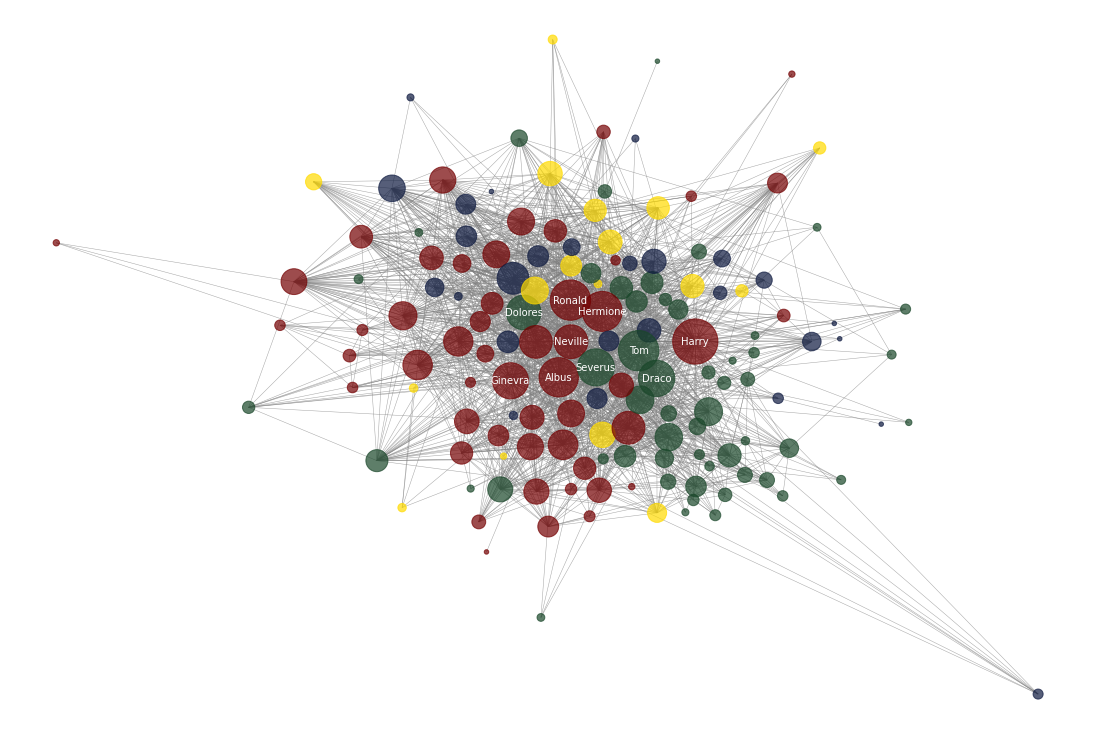

In [289]:
# And we're ready to visualise:
plt.figure(figsize=(15,10))
nx.draw(nx.to_undirected(FINAL), positions, node_color = node_colors, with_labels = False, node_size = node_sizes, edge_color = edge_colors, width=0.5, alpha=0.7);

# Now we draw the labels of the top nodes
nx.draw_networkx_labels(FINAL, positions, labels, font_size = 10, font_color = 'white');

In [290]:
FINAL.degree()

DiDegreeView({'Mandy Brocklehurst': 2, 'Peregrine Derrick': 6, 'Amycus Carrow': 45, 'Hokey': 5, 'Rose Granger-Weasley': 42, 'Lily J. Potter': 59, 'Blaise Zabini': 17, 'Eileen Prince': 5, 'Cormac McLaggen': 28, 'Susan Bones': 59, 'Colin Creevey': 50, 'Justin Finch-Fletchley': 50, 'Fawcett': 7, 'Urquhart': 2, "Marcus Belby's father": 2, 'James Potter II': 43, 'Eloise Midgen': 11, 'Orion Black': 22, 'Zacharias Smith': 43, 'Theodore Nott': 17, 'Lavender Brown': 47, 'Walburga Black': 22, 'Neville Longbottom': 113, 'Godric Gryffindor': 16, 'Evan Rosier': 18, 'Marietta Edgecombe': 28, 'Stebbins (Potter-era)': 4, 'Graham Montague': 18, 'Harper': 6, 'Ernest Macmillan': 56, 'Molly Weasley': 67, 'Oliver Wood': 40, 'Lestrange': 9, 'Odo': 5, 'Rubeus Hagrid': 87, 'Daphne Greengrass': 10, 'Bloody Baron': 22, 'Elladora Black': 7, 'Marcus Belby': 11, 'James Potter I': 49, 'Avery (Marauder-era)': 23, 'Millicent Bulstrode': 24, 'Alicia Spinnet': 55, 'Summerby': 6, 'Demelza Robins': 10, 'Pomona Sprout': 5

# Throwing out non-important characters from network

In [362]:
all_important_nodes = [node for node in DG.nodes if (DG.in_degree(node) > 6 or DG.out_degree(node) > 3) 
                       and DG.degree(node) > 10
                       and "mother" not in node.lower() 
                       and "father" not in node.lower() 
                       and "uncle" not in node.lower()]

nodes_to_remove = [node for node in DG.nodes if node not in all_important_nodes]

DG.remove_nodes_from(nodes_to_remove)

print("Removed {} secondary characters from the network. Network size now: {}".format(len(nodes_to_remove), len(DG.nodes)))

Removed 12 secondary characters from the network. Network size now: 231


----

# Degree distribution analysis

## Histogram and log-log for in- and out-degrees

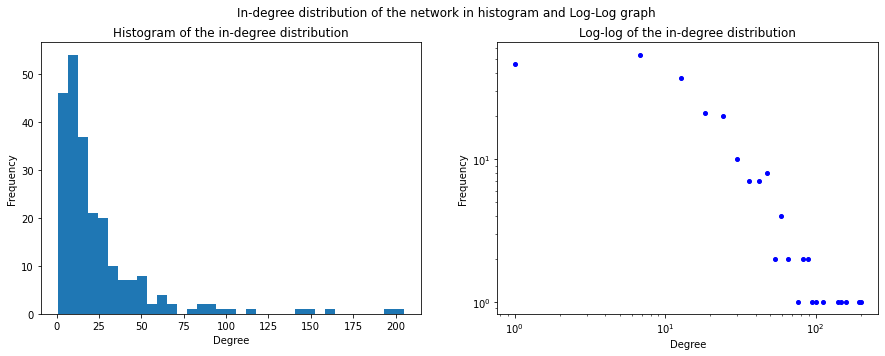

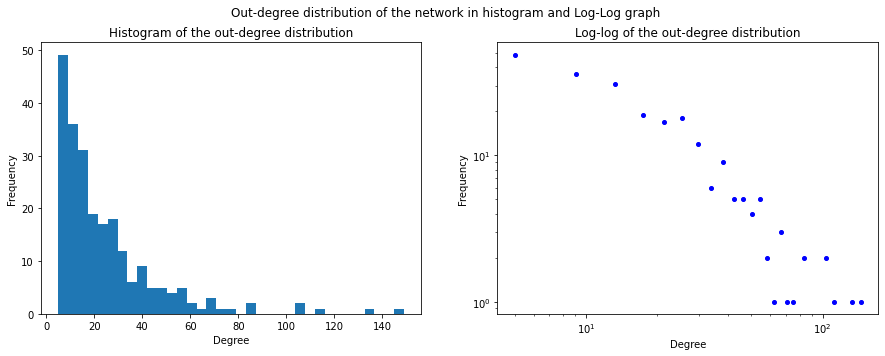

In [363]:
# Plotting the in- and out-degree distributions. 

# Since we're doing the same thing more than once, let's make a function:

def display_histogram_and_loglog_distributions(G_type, print_str, title, bins):
    degs = [deg for (node, deg) in G_type]
    hist, bin_edges = np.histogram(degs, bins=bins)
    degree_sequence = sorted([d for n, d in G_type], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # Side-by-side comparison
    fig.suptitle(title)
    
    axs[0].hist(degs, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title    
    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.show()

display_histogram_and_loglog_distributions(G_type=DG.in_degree(), #Plotting the in-degree distribution
                                           bins=35, 
                                           print_str="in-degree", 
                                           title="In-degree distribution of the network in histogram and Log-Log graph")

display_histogram_and_loglog_distributions(G_type=DG.out_degree(), # Plotting the out-degree distribution
                                           bins=35, 
                                           print_str="out-degree", 
                                           title="Out-degree distribution of the network in histogram and Log-Log graph")


## Scatterplot for in- and out-degrees

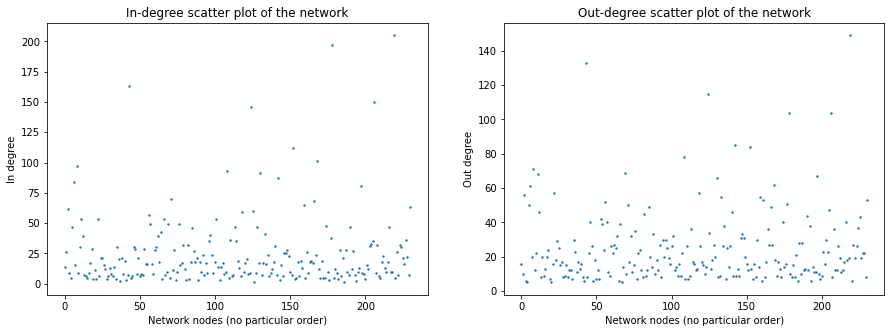

In [364]:
# Defining a scatterplot function to compare the in-degrees and the out-degrees


import random # To shuffle the list
random.seed(15)

node_indices = [i for i in range(len(DG.nodes))] # indices
nodes = [node for node in DG.nodes] # all nodes in network

random.shuffle(nodes) # randomising the list



in_degrees = [DG.in_degree(node) for node in nodes]
out_degrees = [DG.out_degree(node) for node in nodes]

def make_scatter_plots():
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    
    axs[0].scatter(node_indices, in_degrees, s=2) # In-degree scatter
    axs[0].set_xlabel('Network nodes (no particular order)')
    axs[0].set_ylabel('In degree')
    axs[0].set_title('In-degree scatter plot of the network')
    
    axs[1].scatter(node_indices, out_degrees, s=2) # Out-degree scatter
    axs[1].set_xlabel('Network nodes (no particular order)')
    axs[1].set_ylabel('Out degree')
    axs[1].set_title('Out-degree scatter plot of the network')
    
    return axs

axs = make_scatter_plots()
plt.show()

## Scatterplot with in- and out-degrees with percentiles

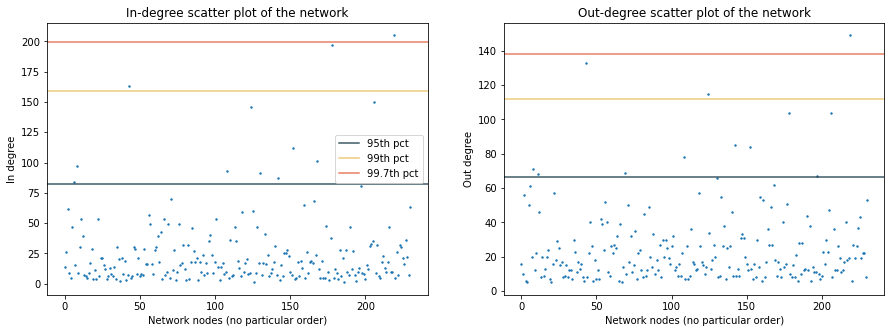

In [365]:
# Finding percentiles

percentiles = [95, 99, 99.7] # Defining three high percentiles to explore
colours = ["#264653", "#e9c46a", "#e76f51"] # And their colours

axs = make_scatter_plots()

for i in range(len(percentiles)):
    # Drawing line for each percentile on each graph
    axs[0].axhline(y=np.percentile(in_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
    axs[1].axhline(y=np.percentile(out_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")

axs[0].legend()
plt.show()

## Scatter plots with labels over a percentile 

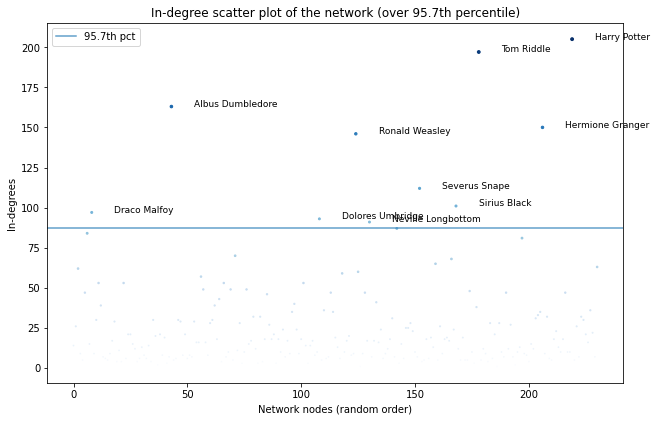

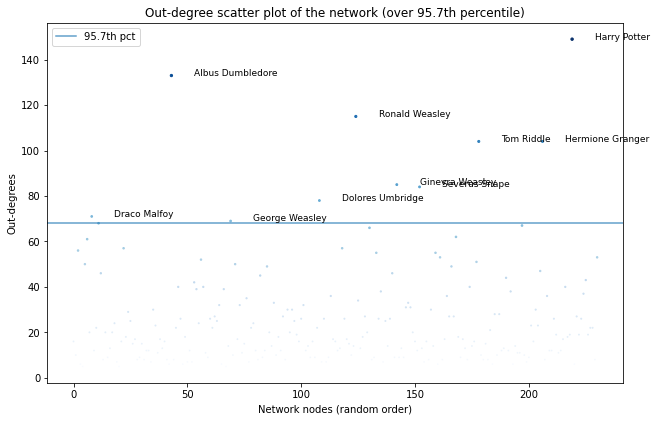

In [367]:
def plot_scatter_with_labels_over_percentile(degs, print_str, title, percentile):
    fig=plt.figure(figsize=(8,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(node_indices, degs, s=[degree / 25 for degree in degs], c=degs, cmap="Blues") # Size map included
    ax.set_xlabel('Network nodes (random order)')
    ax.set_ylabel(print_str)
    #ax.set_ylabel('In degree')
    ax.set_title(title)
    #ax.set_title('In-degree scatter plot of the network (over 99.7th percentile)')

    # Adding the horizontal line for the 99.7th percentile
    plt.axhline(y=np.percentile(degs, percentile), xmin=0, xmax=1, alpha=0.7, label="{}th pct".format(percentile))   

    # And annotating the top degrees
    for n in range(len(degs)):
        if degs[n] > np.percentile(degs, percentile):
            plt.text(n+10, degs[n], nodes[n], fontsize=9)
    
    plt.legend()        
    plt.show()
    
    
    
    
plot_scatter_with_labels_over_percentile(in_degrees, # Nodes to plot
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         95.7 # percentile
                                        )

plot_scatter_with_labels_over_percentile(out_degrees, # Nodes to plot
                                         "Out-degrees", # Axis string
                                         "Out-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         95.7 # percentile
                                        )

In [337]:
all_nodes = [node for node in DG.nodes]
all_important_nodes = [node for node in DG.nodes if (DG.in_degree(node) > 6 or DG.out_degree(node) > 3) 
                       and DG.degree(node) > 10
                       and "mother" not in node.lower() 
                       and "father" not in node.lower() 
                       and "uncle" not in node.lower()
                       and "cousins" not in node.lower()]

print(len(all_important_nodes))

#for node in all_nodes:
#    if node not in all_important_nodes:
#        print(node)

243


In [369]:
for node in DG.nodes:
    print(node)

Lily J. Potter
Petunia Dursley
Blaise Zabini
Susan Bones
Justin Finch-Fletchley
Rolanda Hooch
Marjorie Dursley
Theodore Nott
Lavender Brown
Cuthbert Binns
Neville Longbottom
Molly Weasley
Oliver Wood
Rubeus Hagrid
Bloody Baron
James Potter I
Millicent Bulstrode
Dudley Dursley
Alicia Spinnet
Irma Pince
Pomona Sprout
Garrick Ollivander
Fred Weasley
Dean Thomas
Vincent Crabbe
Sirius Black
Dedalus Diggle
Draco Malfoy
Newton Scamander
Griphook
Gellert Grindelwald
Hannah Abbott
Nicolas Flamel
Augusta Longbottom
Padma Patil
Argus Filch
Seamus Finnigan
Harry Potter
Firenze
Gregory Goyle
Parvati Patil
George Weasley
Terry Boot
Angelina Johnson
Arabella Figg
Peeves
Poppy Pomfrey
William Weasley
Helena Ravenclaw
Katie Bell
Tom Riddle
Albus Dumbledore
Filius Flitwick
Arthur Weasley
Cornelius Fudge
Nicholas de Mimsy-Porpington
Tom
Bathilda Bagshot
Hermione Granger
Minerva McGonagall
Severus Snape
Charles Weasley
Peter Pettigrew
Ronald Weasley
Lucius Malfoy
Marcus Flint
Vernon Dursley
Narcissa Malfo

In [370]:
# As with any visualisation - it's mostly about sizes and colour:
DG_GCC = DG.subgraph(max(nx.weakly_connected_components(DG), key=len))

# First generate a subgraph with only the characters that have a specified house and some in degrees
house_nodes = [
    node
    for node, data
    in DG_GCC.nodes(data=True)
    if data.get("house") != None
]

# Create subgraph of the houses
DG_GCC_House = DG_GCC.subgraph(house_nodes).copy()

# Create subgraph of those in houses with indegrees
has_in_degrees = [node for (node, degree) in DG_GCC_House.in_degree() if degree > 0]
has_out_degrees = [node for (node, degree) in DG_GCC_House.out_degree() if degree > 0]

has_degrees = list(set(has_in_degrees).intersection(set(has_out_degrees)))

DG_GCC_House_Degree = DG_GCC_House.subgraph(has_degrees).copy()

FINAL = DG_GCC_House_Degree.subgraph(max(nx.weakly_connected_components(DG_GCC_House_Degree), key=len))

# Define house colors
house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Create lists of the correct colors and sizes for edges and nodes
edge_colors = [grey for (u,v) in FINAL.edges]

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in FINAL.nodes.data('house')]

# Node sizes based on degree centrality value
node_sizes = [value*1500 for value in nx.degree_centrality(FINAL).values()] #FINAL.degree()

# Let's find the 'biggest' nodes
top_nodes = dict(sorted(nx.degree_centrality(FINAL).items(), key = itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in FINAL.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]

In [371]:
# If you can get it to work, get node positions based on the Force Atlas 2 algorithm

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(FINAL, pos=None, iterations=1000);

100%|██████████| 1000/1000 [00:00<00:00, 1005.96it/s]

BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.67  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


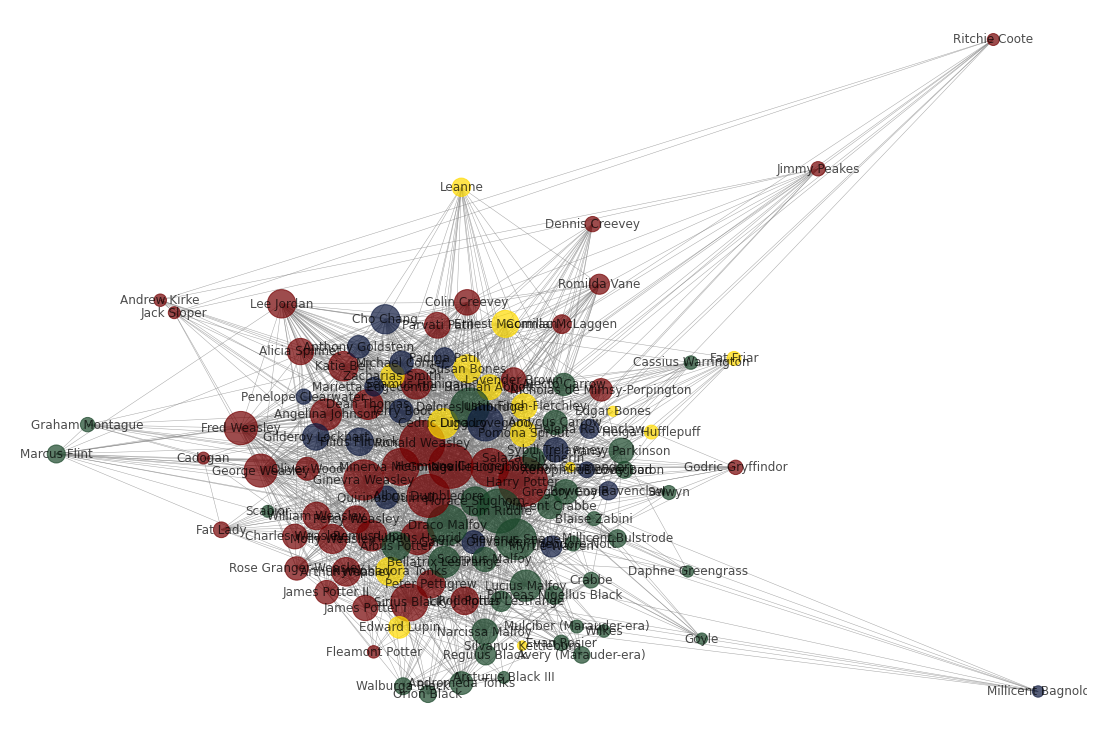

In [373]:
# And we're ready to visualise:
plt.figure(figsize=(15,10))
nx.draw(nx.to_undirected(FINAL), positions, node_color = node_colors, with_labels = True, node_size = node_sizes, edge_color = edge_colors, width=0.5, alpha=0.7);

# Now we draw the labels of the top nodes
#nx.draw_networkx_labels(FINAL, positions, labels, font_size = 10, font_color = 'white');

In [159]:
# TO KEEP 

aliases = {
    "Keeper of Keys and Grounds":"Hagrid"
}

non_character_nodes = [
    "Quirinus Quirrell's first mountain troll",
    "Prewett family",
    "King's Cross Station",
    "Hogwarts acceptance letter",
    "Hogwarts Express",
    "Piers Polkiss's mother",
    "Charlie Weasley's colleagues",
    "Diagon Alley",
    "Forbidden Forest",
    "Madam Malkin's Robes for All Occasions",
    "Dudley Dursley's tortoise",
    "Enid (disambiguation)", # enid pettigrew
    "Boa constrictor at the Zoo",
    "Mirror of Erised",
    "Evans sisters' mother",
    "Vernon Dursley's secretary",
    "Seamus Finnigan's mother",
    "Piers Polkiss's mother",
    "King's Cross Station guard",
    "Lee Jordan's tarantula",
    "Bones family",
    "Gringotts Head Goblin",
]